# Dataset

In [1]:
DATASET = {'20Hz_condition':[\
                              {'Control':['nm02Mar2018c0_000_ctrl.h5'],
                               'Tricine':['nm02Mar2018c0_001_tricine.h5']},
                              {'Control':['nm02Mar2018c1_000_ctrl.h5'],
                               'Tricine':['nm02Mar2018c1_002_tricine.h5']},
                              {'Control':['nm02Mar2018c2_000_ctrl.h5'],
                               'Tricine':['nm02Mar2018c2_002_tricine.h5']},
                              {'Control':['nm30Mar2018c1_000_ctrl.h5'],
                               'Tricine':['nm30Mar2018c1_004_tricine.h5']},
                              #{'Control':['nm17Apr2019c1_000.h5'],
                              # 'Tricine':['nm17Apr2019c1_001.h5']},
                            ],
           '3Hz_condition':[\
                             {'Control':['nm18Sep2019c1_000.h5'],
                              'Tricine':['nm18Sep2019c1_001.h5']},
                             {'Control':['nm19Sep2019c1_001.h5'],
                              'Tricine':['nm19Sep2019c1_002.h5']},
                             {'Control':['nm20Sep2019c1_001.h5'],
                              'Tricine':['nm20Sep2019c1_003.h5']},
                             #{'Control':['nm30Aug2019c0_000.h5'],
                             # 'Tricine':['nm30Aug2019c0_002.h5']},
                             {'Control':['nm18Sep2019c4_000.h5'],
                              'Tricine':['nm18Sep2019c4_003.h5']},
                             {'Control':['nm19Sep2019c2_001.h5'],
                              'Tricine':['nm19Sep2019c2_004.h5']},
                             {'Control':['nm23Sep2019c2_001.h5'],
                              'Tricine':['nm23Sep2019c2_002.h5']},
            ],
}


In [7]:
import os, sys
import numpy as np
from analyz.IO.igor import load_hdf5_exported_from_Igor as load_data
%matplotlib inline
from datavyz import gedn as ge

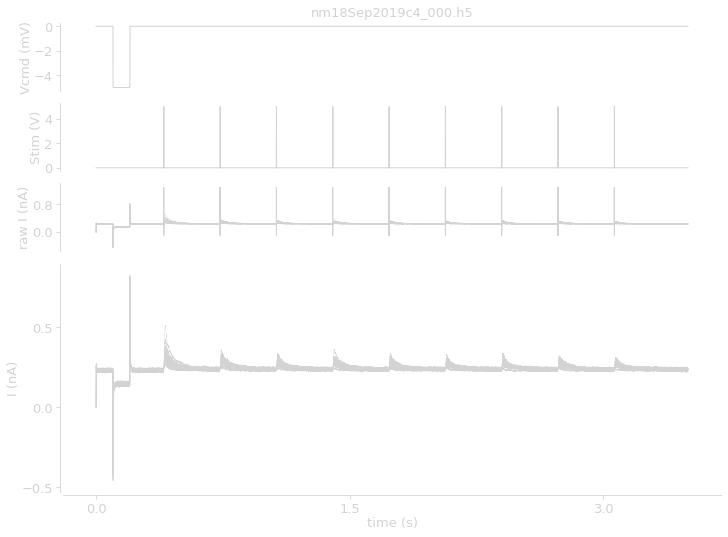

In [318]:

def abbrev_to_month(abbrev):
    M = ['January', 'February', 'March', 'April', 'May',\
         'June', 'July', 'August', 'September', 'October',\
         'November', 'December']
    for m in M:
        if (m[:3].lower()==abbrev.lower()):
            return m

        
def filename_to_path(filename):
    day, month, year = filename[2:4], filename[4:7], filename[7:11]
    cell = filename[11:13]
    cond = filename[14:17]
    return os.path.join(year, abbrev_to_month(month), filename[:13], filename)


def plot_protocol(D):
    fig, AX = ge.figure(axes_extents=[[[3,1]] for i in range(3)]+[[[3,3]]], hspace=0.3, figsize=(1,.6))
    ge.title(AX[0], D['filename'].split(os.path.sep)[-1])
    ge.plot(1e-3*D['t'], D['stimulations'][D['Vcmd_key']], ax=AX[0], axes_args={'spines':['left'], 'ylabel':'Vcmd (mV)'})
    ge.plot(1e-3*D['t'], D['stimulations'][D['stim_key']], ax=AX[1], axes_args={'spines':['left'], 'ylabel':'Stim (V)'})
    for i in range(D['recordings'][D['Irec_key']].shape[0]):
        AX[2].plot(1e-3*D['t'], D['recordings'][D['Irec_key']][i,:], color='lightgray', lw=0.3) 
    ge.plot(1e-3*D['t'], D['recordings'][D['Irec_key']].mean(axis=0), ax=AX[2],
            axes_args={'spines':['left'], 'ylabel':'raw I (nA)'})
    # now blanking the stimulus period
    for i in range(D['recordings'][D['Irec_key']].shape[0]):
        AX[3].plot(1e-3*D['t'], D['recordings']['Irecording_clean'][i,:], color='lightgray', lw=0.3) 
    ge.plot(1e-3*D['t'], D['recordings']['Irecording_clean'].mean(axis=0), ax=AX[3],
            axes_args={'xlabel':'time (s)', 'ylabel':'I (nA)'})

    
def LoadData(protocol,
             iexp=0, condition='Control', irec=0,
             dt_subampling=0,
             Fcutoff = 2000., # for low pass filtering
             verbose=False):
    if sys.platform=='win32': # Windows
        root_folder = 'C:\\'
    else:
        root_folder = '/media/yann/Windows'
    root_folder = os.path.join(root_folder, 'Users', 'yann.zerlaut', 'Documents', 'DATA', 'Data_Nunzio')

    fn = os.path.join(root_folder, filename_to_path(DATASET[protocol][iexp][condition][irec]))
    try:
        data = load_data(fn, dt_subsampling=dt_subampling, verbose=verbose)
        data['filename'] = fn
        if 'stim' in data['stimulations']:
            data['stim_key'] = 'stim'
        else:
            data['stim_key'] = 'Stimulator'
        if 'Vcommand2' in data['stimulations']:
            data['Vcmd_key'] = 'Vcommand2'
        else:
            data['Vcmd_key'] = 'Vcommand'
        if 'Irecording2' in data['recordings']:
            data['Irec_key'] = 'Irecording2'
        else:
            data['Irec_key'] = 'Irecording'
    except (UnboundLocalError, KeyError):
        print('/!\ -- File corrupted ! -- /!\ ')
        print(fn)
        from analyz.IO.hdf5 import load_dict_from_hdf5
        data = load_dict_from_hdf5(fn)
    if Fcutoff>0:
        # adding low pass filtering
        Facq = 1./(data['t'][1]-data['t'][0])*1e3
        for i in range(data['recordings'][data['Irec_key']].shape[0]):
            data['recordings'][data['Irec_key']][i,:] =\
                butter_lowpass_filter(data['recordings'][data['Irec_key']][i,:], Fcutoff, Facq, order=5)
        
    data = remove_stimulation_artefact(data)
        
    return data

def remove_stimulation_artefact(D,
                                Tborder=2, # both in ms
                                Twindow=0.01):
    """
    For comparison with the theoretical model, the electrical artefact following extracellular stimulation in the voltage-clamp recordings was removed. This was performed by replacing the values during stimulation (TTL>0mV) by a linear interpolation of the signal using the pre- and post-stimulus recorded value.
    """
    iborder = int(Tborder/(data['t'][1]-data['t'][0])) # Tborder & t in ms
    iwindow = int(Twindow/(data['t'][1]-data['t'][0])) # Tborder & t in ms
    D['recordings']['Irecording_clean'] = 1.*D['recordings'][D['Irec_key']]
    rounded_stim = np.round(D['stimulations'][D['stim_key']],0)
    threshold = np.mean(np.unique(rounded_stim))/2.
    iup = np.argwhere((rounded_stim[1:]>threshold) & (rounded_stim[:-1]<=threshold)).flatten()
    idown = np.argwhere((rounded_stim[1:]<=threshold) & (rounded_stim[:-1]>=threshold)).flatten()

    for i0, i1 in zip(iup, idown):
        Y0 = D['recordings'][D['Irec_key']][:,i0-iborder-iwindow:i0-iborder].mean(axis=1)
        Y1 = D['recordings'][D['Irec_key']][:,i1+iborder:i1+iborder+iwindow].mean(axis=1)
        for i in range(i0-iborder, i1+iborder):
            # linear interpolation with respect to stimulus borders
            D['recordings']['Irecording_clean'][:,i] = Y0+(Y1-Y0)*(i-(i0-iborder))/(i1-i0+2*iborder)
    return D

#data = remove_stimulation_artefact(data)
plot_protocol(data)


100000.0


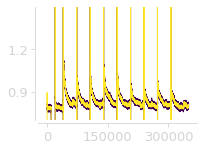

In [241]:
from analyz.processing.filters import butter_lowpass_filter
data = LoadData('3Hz_condition', iexp=5, condition='Control')

Fcutoff = 2000.
Facq = 1./(data['t'][1]-data['t'][0])*1e3
print(Facq)
_, ax = ge.plot(Y=[data['recordings'][data['Irec_key']][0],
           butter_lowpass_filter(data['recordings'][data['Irec_key']][0], Fcutoff, Facq, order=5)])
ge.set_plot(ax, ylim=[0.7,1.5])

# data['recordings']

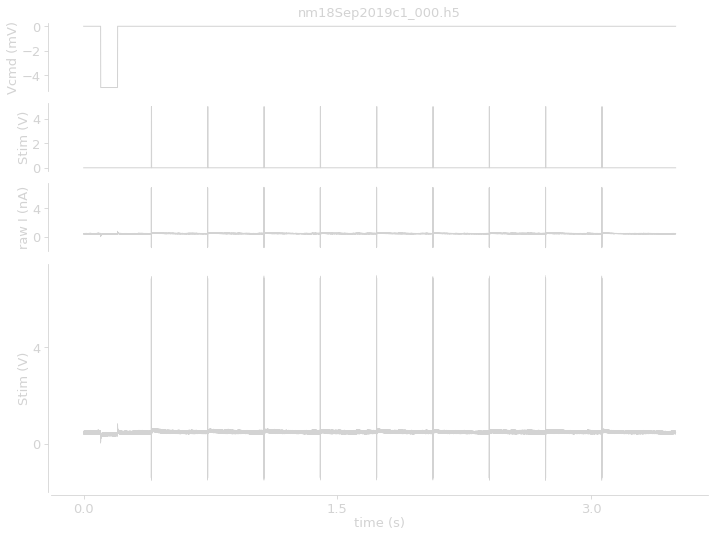

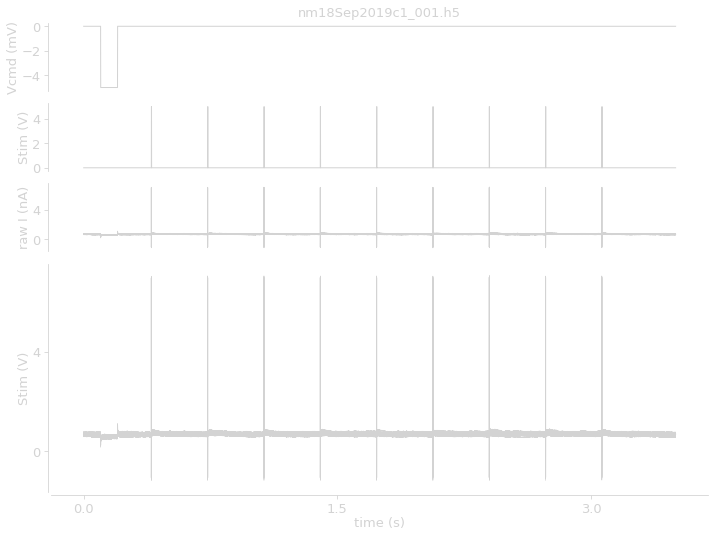

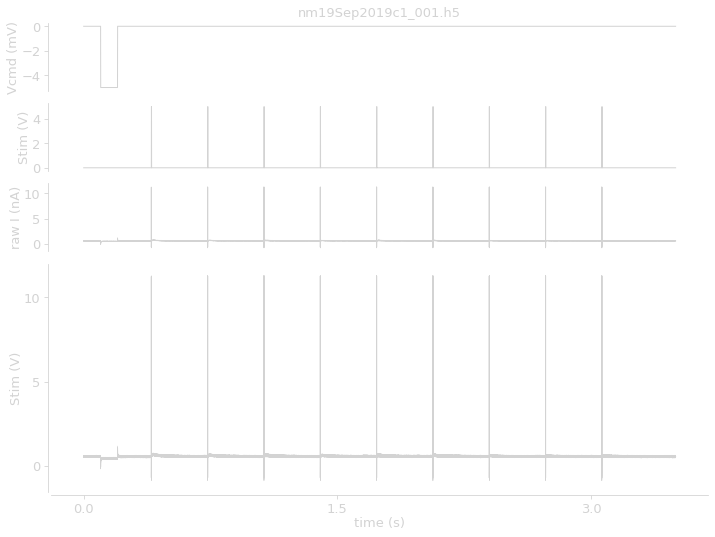

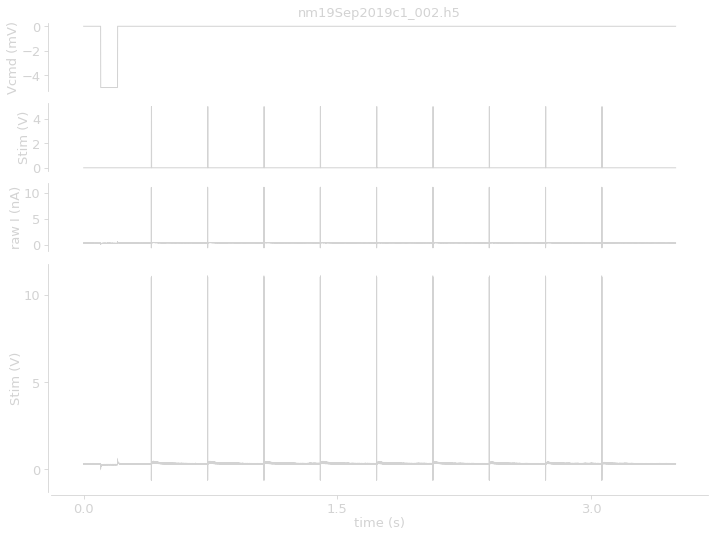

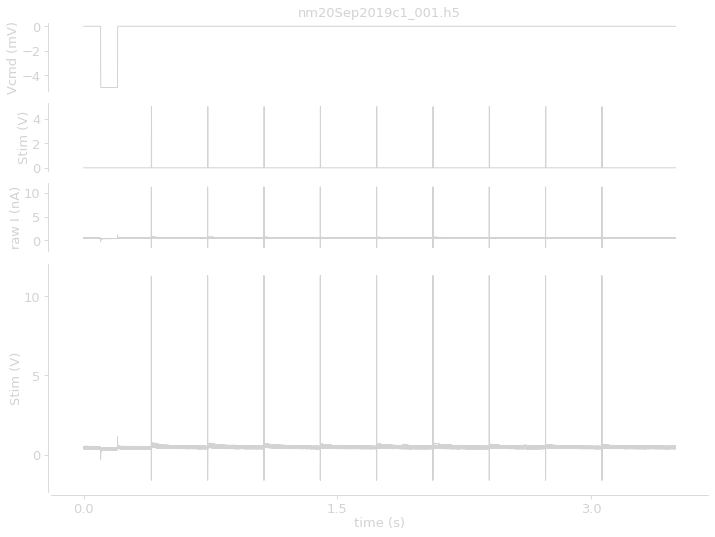

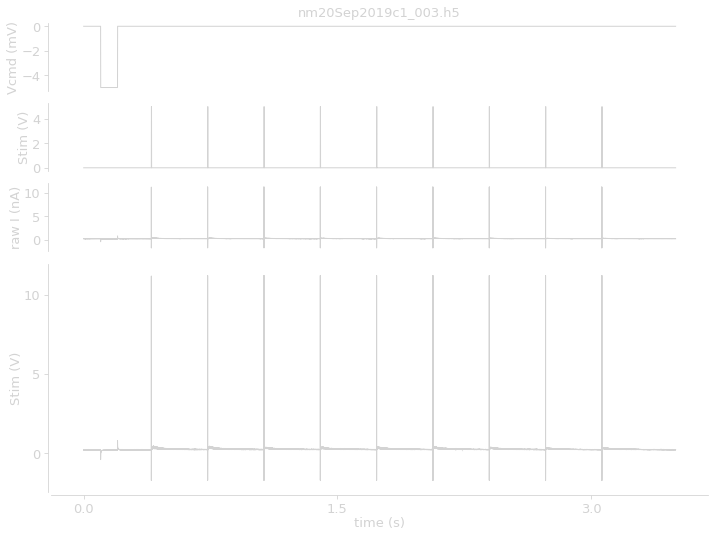

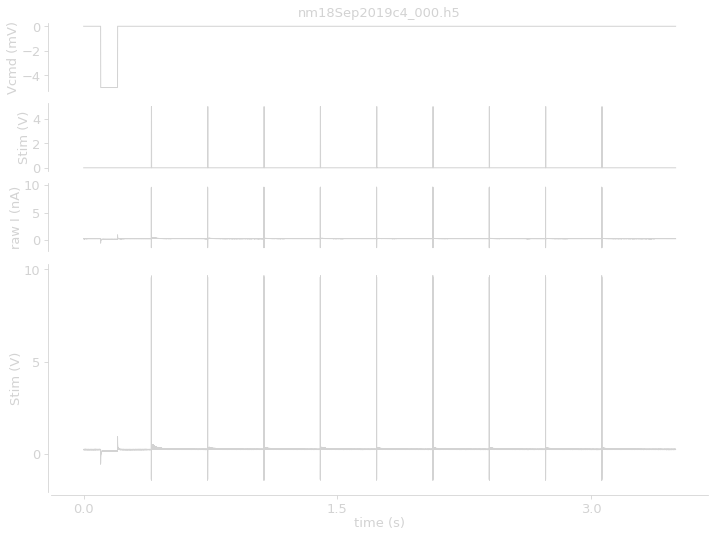

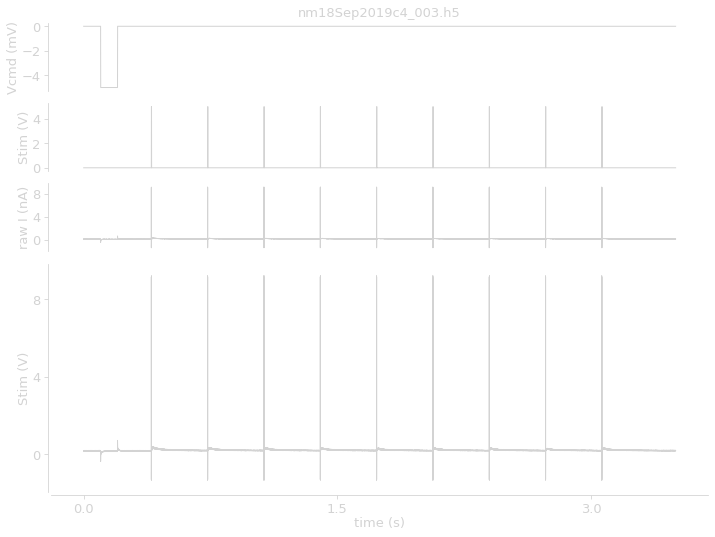

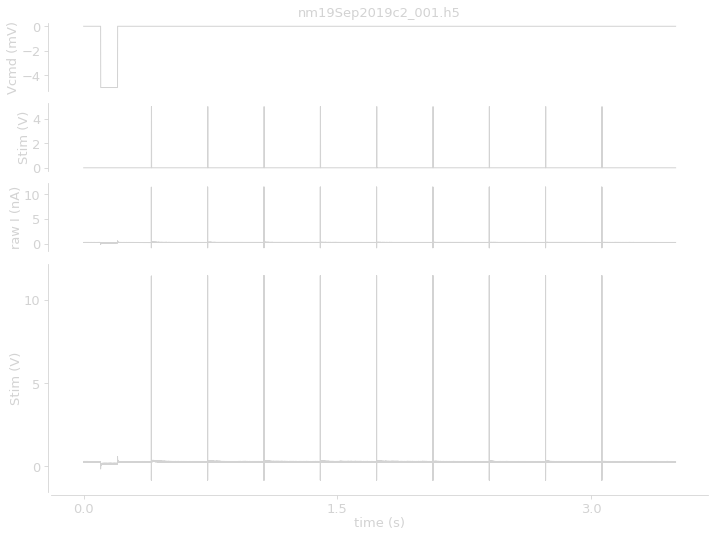

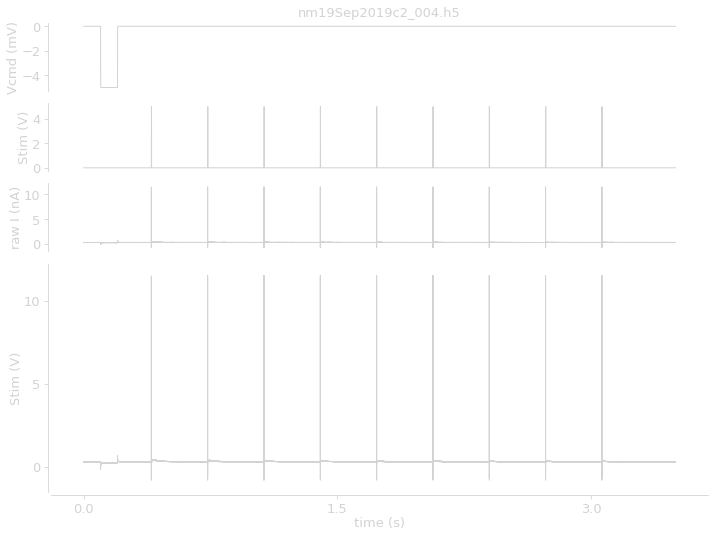

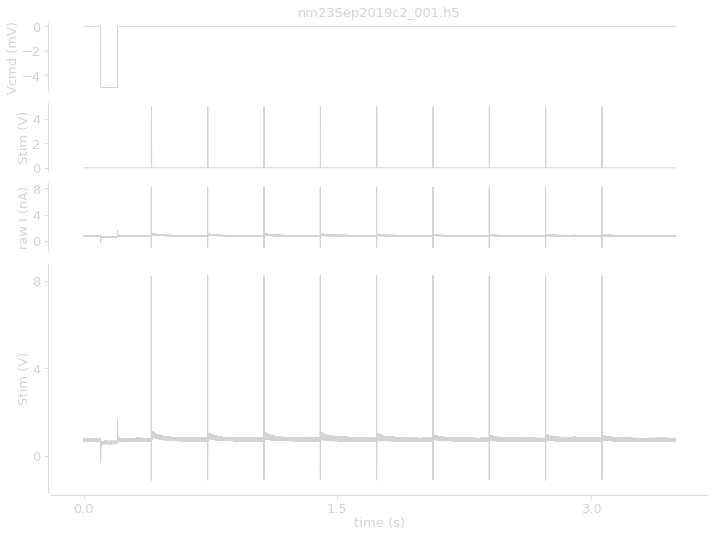

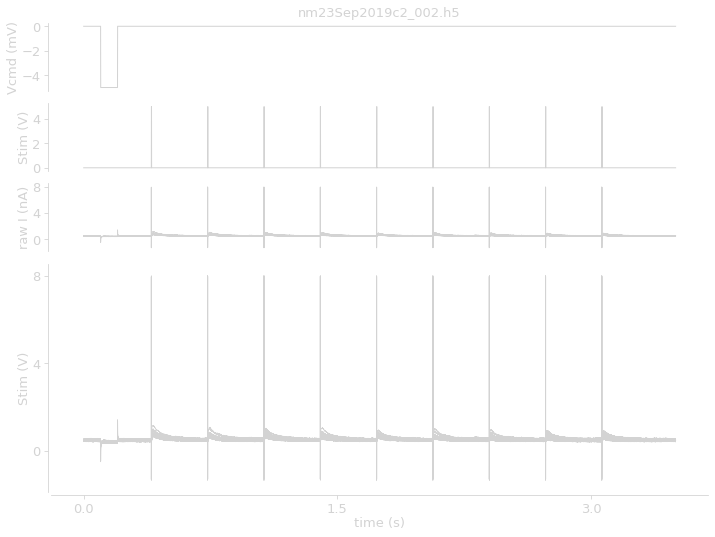

In [128]:
cond = '3Hz_condition'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    plot_protocol(data_ctrl)
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    plot_protocol(data_test)

In [325]:
def compute_norm_trace(data,
                       window_for_peak=20, # ms
                       pre_window = 150, # ms
                       t0=400,
                       with_all=False):

    tcond = (data['t']>t0-pre_window)
    baseline_cond = (data['t']>t0-pre_window) & (data['t']<t0)
    baseline = data['recordings']['Irecording_clean'].mean(axis=0)[baseline_cond].mean()

    trace = data['recordings']['Irecording_clean'].mean(axis=0)[tcond]-baseline
    stim = data['stimulations'][data['stim_key']][tcond]
    stim_events = np.argwhere((stim[:-1]<2) & (stim[1:]>=2)).flatten()
    peak_cond = (data['t'][tcond]>=t0) & (data['t'][tcond]<=t0+window_for_peak)

    norm_trace = trace/np.max(trace[peak_cond])

    if with_all:
        return data['t'][tcond], stim_events, norm_trace, np.max(trace[peak_cond])
    else:
        return norm_trace

    
def protocol_comparison(DATA,
                        labels=['Control', 'Tricine'],
                        colors=['k', ge.green],
                        window_for_peak=20, # ms
                        pre_window = 150, # ms
                        t0=400):
    fig, AX = ge.figure(axes=(1,3), figsize=(2,1.3), hspace=0.3)
    for data, c in zip(DATA, colors):
        AX[0].plot(1e-3*data['t'], data['recordings'][data['Irec_key']].mean(axis=0), color=c)
    ge.set_plot(AX[0], ['left'], ylabel='raw-I (nA)')

    for data, label, c in zip(DATA, labels, colors):
        tcond = (data['t']>t0-pre_window)
        baseline_cond = (data['t']>t0-pre_window) & (data['t']<t0)
        baseline = data['recordings']['Irecording_clean'].mean(axis=0)[baseline_cond].mean()
        trace = data['recordings']['Irecording_clean'].mean(axis=0)[tcond]-baseline
        
        peak_cond = (data['t'][tcond]>t0) & (data['t'][tcond]<t0+window_for_peak)
        norm_trace = compute_norm_trace(data, window_for_peak, pre_window, t0)
        
        AX[1].plot(1e-3*data['t'][tcond], trace, color=c, label=label)
        AX[2].plot(1e-3*data['t'][tcond], norm_trace, color=c, label=label)
        
    ge.set_plot(AX[1], ['left'], ylabel='I (nA)\n (-baseline&stim)')
    ge.set_plot(AX[2], xlabel='time (s)', ylabel='I (nA)\n (-baseline&stim)\n (+rescaled)')
    
    ge.legend(AX[1])
    return fig, AX

t, trace, factor = compute_norm_trace(data, with_all=True)
ge.plot(t, trace)
trace

ValueError: too many values to unpack (expected 3)

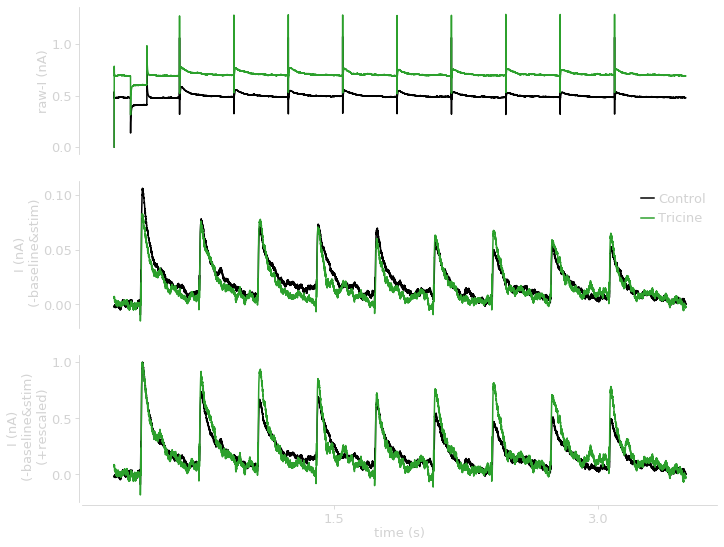

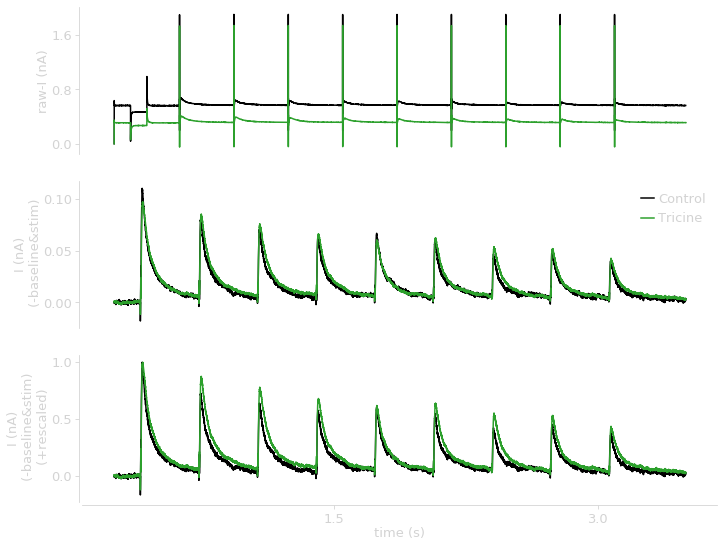

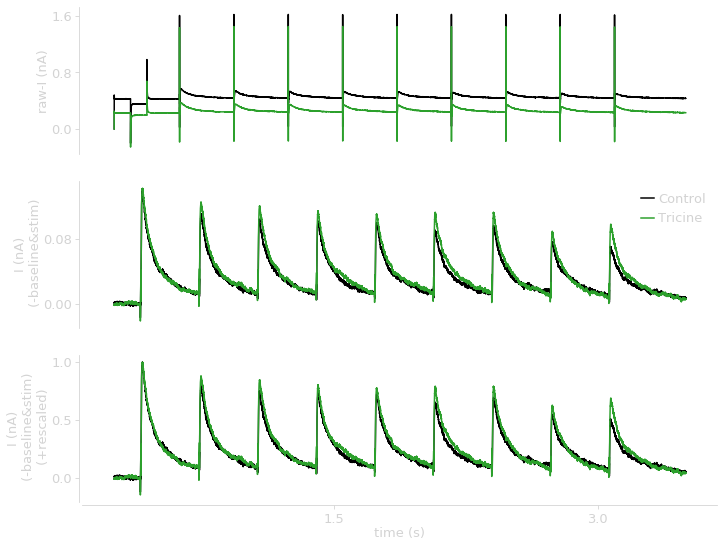

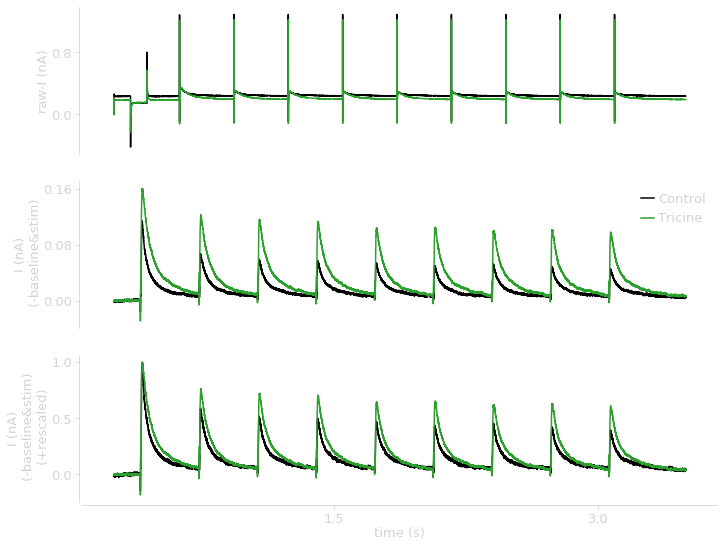

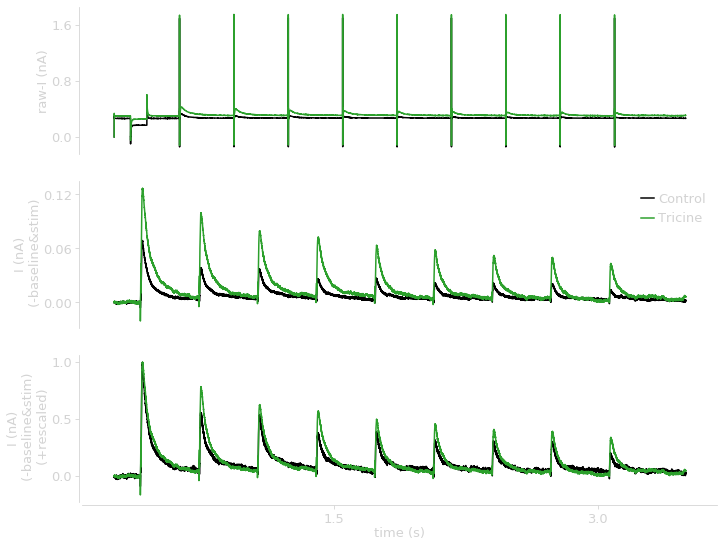

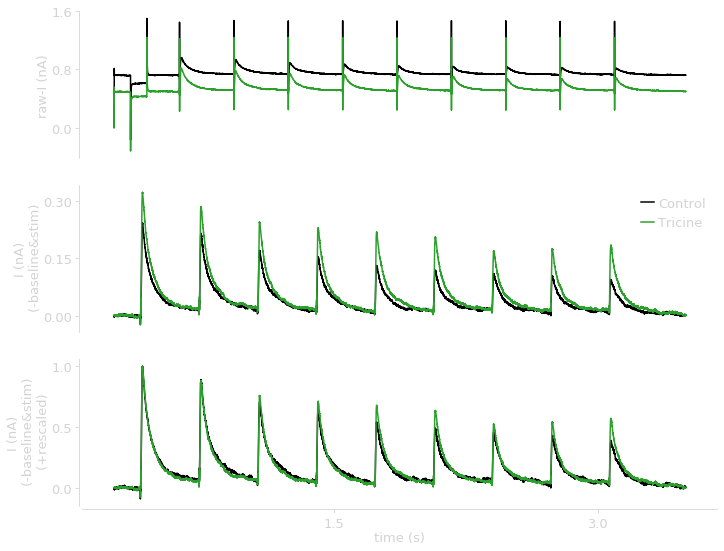

In [249]:
cond = '3Hz_condition'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    protocol_comparison([data_ctrl, data_test])

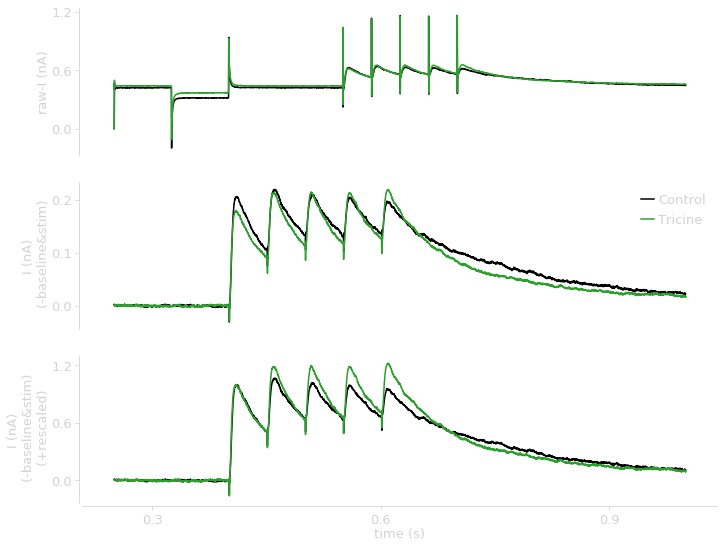

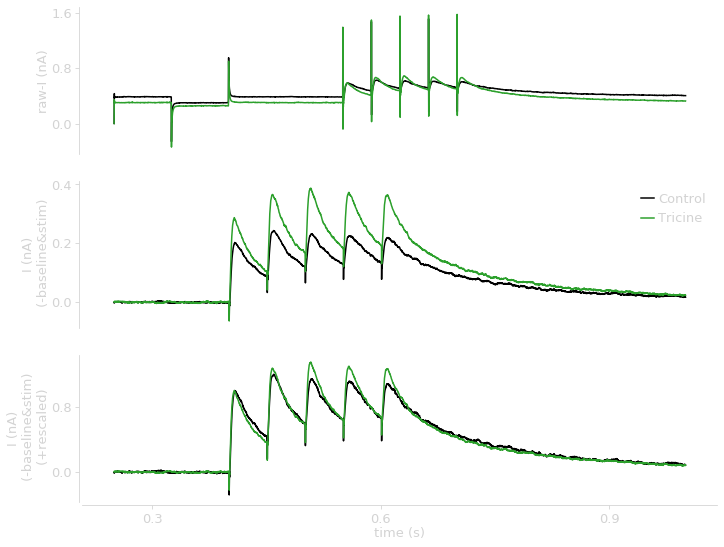

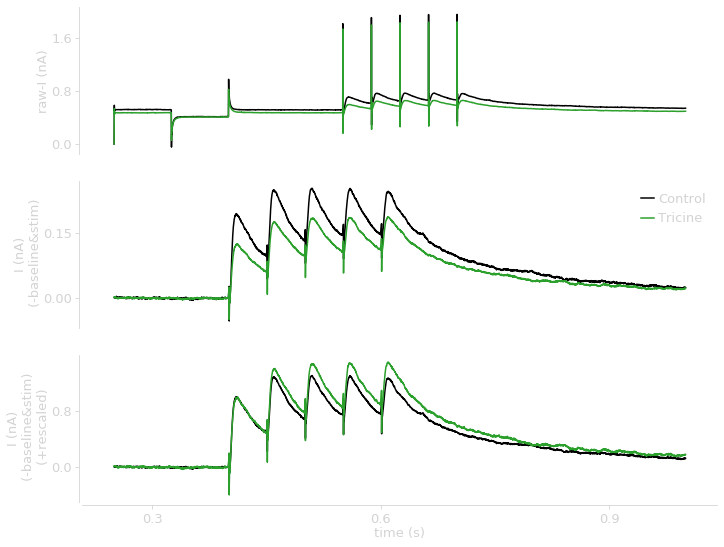

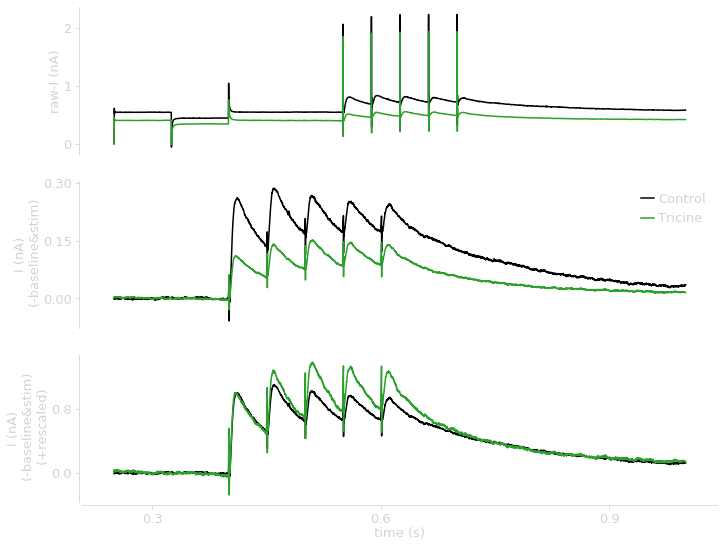

In [292]:
cond = '20Hz_condition'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    protocol_comparison([data_ctrl, data_test])

In [424]:

FDATA = {}
for cond in ['3Hz_condition', '20Hz_condition']:
    norm_trace_ctrl, norm_trace_test = [], []
    scale_ctrl, scale_test = [], []
    for i, cell in enumerate(DATASET[cond]):
        data_ctrl = LoadData(cond, iexp=i, condition='Control')
        t, se, n_trace, scale = compute_norm_trace(data_ctrl,
                                            window_for_peak=20,
                                            pre_window = 150,
                                            t0=400, with_all=True)
        norm_trace_ctrl.append(n_trace)
        scale_ctrl.append(scale)
        data_test = LoadData(cond, iexp=i, condition='Tricine')
        t, se, n_trace, scale = compute_norm_trace(data_test,
                                            window_for_peak=20,
                                            pre_window = 150,
                                            t0=400, with_all=True)
        norm_trace_test.append(n_trace)
        scale_test.append(scale)
    FDATA[cond] = {'norm_trace_ctrl':np.array(norm_trace_ctrl),
                   'norm_trace_test':np.array(norm_trace_test),
                   't':t,
                   'se':se,
                   'scale_ctrl':np.array(scale_ctrl),
                   'scale_test':np.array(scale_test)}


In [426]:
# toy model data


def build_stimulation():
    
    dt, tstop = 0.1, 5000.
    t = np.arange(int(tstop/dt))*dt
    model = {'t':t}
    y = 0*t
    events = np.empty(0)
    for cond, t0, freq_pulses, n_pulses in zip(['20Hz_condition', '3Hz_condition'],
                                               [500,1700], [20., 3.], [5, 9]) :

        new_events = t0+np.arange(n_pulses)*1e3/freq_pulses
        events = np.concatenate([events, new_events])
        model['%s_tstart' % cond] = t0
    model['events'] = events
    return model

model = build_stimulation()
# adding a fa
dt = model['t'][1]-model['t'][0]
for te in model['events']:
    y[int(te/dt):] += double_exponential(model['t'][int(te/dt):]-model['t'][int(te/dt)], 5., 70.)
model['I'] = y



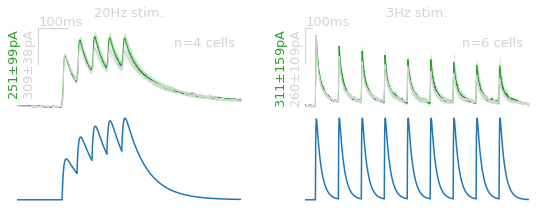

In [427]:
T = 100

fig, AX = ge.figure(axes=(2,2), figsize=(1.2,0.8),
                    wspace=0.5, hspace=0)

for cond, ax, I0, t0, DI in zip(['20Hz_condition', '3Hz_condition'], AX[0], [1.5, 1.1],
                                [t[0]+70, t[0]], [0.7, 0.5]):

    ax.plot([t0, t0], [I0,I0-DI], lw=1, color=ge.default_color)
    ax.plot([t0, t0+T], [I0, I0], lw=1, color=ge.default_color)
    ge.annotate(ax, '%.0f$\pm$%.0fpA' % (1e3*FDATA[cond]['scale_ctrl'].mean()/DI,
                1e3*FDATA[cond]['scale_ctrl'].std()/DI),
                (t0, I0), xycoords='data', rotation=90, ha='right', va='top')
    ge.annotate(ax, '%.0f$\pm$%.0fpA\n' % (1e3*FDATA[cond]['scale_test'].mean()/DI,
                1e3*FDATA[cond]['scale_test'].std()/DI),
                (t0, I0), xycoords='data', rotation=90, ha='right', color=ge.green, va='top')
    ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_test'].mean(axis=0),
            sy=FDATA[cond]['norm_trace_test'].std(axis=0), ax=ax, color=ge.green)
    ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_ctrl'].mean(axis=0),
            sy=FDATA[cond]['norm_trace_ctrl'].std(axis=0), ax=ax)
    ge.annotate(ax, 'n=%i cells' % len(FDATA[cond]['norm_trace_ctrl']), (.7,.7))
    ge.annotate(ax, '%ims' % T, (t0, I0), xycoords='data')
    ge.set_plot(ax,[], xlim=[FDATA[cond]['t'][0], FDATA[cond]['t'][-1]])
    ge.title(ax, '%sHz stim.' % cond.split('Hz')[0])

for cond, ax in zip(['20Hz_condition', '3Hz_condition'], AX[1]):
    DT0 = FDATA[cond]['t'][FDATA[cond]['se'][0]]-FDATA[cond]['t'][0]
    DTfull = FDATA[cond]['t'][-1]-FDATA[cond]['t'][0]

    tcond = (model['t']>(model['%s_tstart' % cond]-DT0)) &\
        (model['t']<(model['%s_tstart' % cond]-DT0+DTfull))
    
    ax.plot(model['t'][tcond], model['I'][tcond])
    ge.set_plot(ax,[], xlim=[model['t'][tcond][0], model['t'][tcond][-1]])

    

# Simulation with different parameters

In [365]:
from neural_network_dynamics import main as ntwk
from model import Model

In [428]:
# build stimulation

stim = build_stimulation()
print(stim)

{'t': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 4.9997e+03, 4.9998e+03,
       4.9999e+03]), '20Hz_condition_tstart': 500, '3Hz_condition_tstart': 1700, 'events': array([ 500.        ,  550.        ,  600.        ,  650.        ,
        700.        , 1700.        , 2033.33333333, 2366.66666667,
       2700.        , 3033.33333333, 3366.66666667, 3700.        ,
       4033.33333333, 4366.66666667])}


In [430]:
from single_cell_sim import initialize_sim, EXC_SYNAPSES_EQUATIONS, ON_EXC_EVENT

def run_single_sim(Model, stim,
                   Vcmd = 0,
                   synapses_loc = 2450+np.arange(10)):

    Model['VC-cmd'] = Vcmd
    Model['tstop'] = stim['t'][-1]
    
    # initialize voltage-clamp sim
    t, neuron, SEGMENTS = initialize_sim(Model, method='voltage-clamp')

    spike_IDs, spike_times = np.empty(0, dtype=int), np.empty(0, dtype=float)
    for te in stim['events']:
        spike_times = np.concatenate([spike_times,
                                      te*np.ones(len(synapses_loc))])
        spike_IDs = np.concatenate([spike_IDs,np.arange(len(synapses_loc))])
    
    Estim, ES = ntwk.process_and_connect_event_stimulation(neuron,
                                                           spike_IDs, spike_times,
                                                           synapses_loc,
                                                           EXC_SYNAPSES_EQUATIONS.format(**Model),
                                                           ON_EXC_EVENT.format(**Model))

    # recording and running
    M = ntwk.StateMonitor(neuron, ('v'), record=[0, synapses_loc[0]])
    S = ntwk.StateMonitor(ES, ('X', 'gAMPA', 'gRiseNMDA', 'gDecayNMDA', 'bZn'), record=[0])

    # # Run simulation
    ntwk.run(Model['tstop']*ntwk.ms)

    output = {'t':np.array(M.t/ntwk.ms), 'Vcmd':Vcmd}
    output['Vm_soma'] = np.array(M.v/ntwk.mV)[0,:]
    output['gAMPA_syn'] = np.array(S.gAMPA/ntwk.nS)[0,:]
    output['X_syn'] = np.array(S.X)[0,:]
    bZn, gRise, gDecay = np.array(S.bZn)[0,:], np.array(S.gRiseNMDA)[0,:], np.array(S.gDecayNMDA)[0,:]
    output['Vm_syn'] = np.array(M.v/ntwk.mV)[1,:]
    output['bZn_syn'] = bZn
    output['gNMDA_syn'] = Model['qNMDA']*Model['nNMDA']*(gDecay-gRise)/(1+0.3*np.exp(-output['Vm_syn']/Model['V0NMDA']))*(1.-Model['alphaZn']*bZn)
    output['Ic'] = (output['Vm_soma']-Model['VC-cmd'])*Model['VC-gclamp'] # nA
                                                                        
    return output

output = run_single_sim(Model, stim)

INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.01s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]
WARNING    "dt" is an internal variable of group "synapses", but also exists in the run namespace with the value 0.1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


(<Figure size 294.803x260.787 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb692605290>)

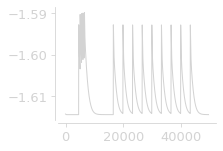

In [435]:
ge.plot(output['Ic'][500:])